In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import math
from sklearn import linear_model

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
from scipy.optimize import curve_fit
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [40]:
with open('hills.txt') as f:
    lines = f.readlines()
    
full_data = list()
for line in lines[1:]:
    arr = line.replace('\t', ' ').replace('\n', '').split(' ')
    full_data.append(arr[1:])
full_data = np.array(full_data)

In [41]:
columns = lines[0].replace('\t', ' ').replace('\n', '').split(' ')
columns

['Race', 'Distance', 'Climb', 'Time']

In [42]:
full_data.shape

(35, 3)

In [54]:
indices = [i for i in range(35) if i not in [17, 18, 29]]

X = full_data[indices, :-1].astype('float32')
y = full_data[indices, -1].astype('float32')

In [55]:
X.shape, y.shape

((32, 2), (32,))

<h1>BOXCOX</h1>

In [56]:
X_ = np.array([X[:, 0], X[:, 1]]).T
#X_[:, 1] = X[:, 1] / X[:, 1].mean()
Y_ = np.array(y)
#Y_ /= Y_.mean()

In [57]:
Y_

array([ 16.083,  48.35 ,  33.65 ,  45.6  ,  62.267,  73.217, 204.617,
        36.367,  29.75 ,  39.75 , 192.667,  43.05 ,  65.   ,  44.133,
        26.933,  72.25 ,  98.417,  32.567,  15.95 ,  27.9  ,  47.633,
        17.933,  18.683,  26.217,  34.433,  28.567,  50.5  ,  85.583,
        32.383, 170.25 ,  28.1  , 159.833], dtype=float32)

In [58]:
def get_fitted(x, y):
    X = pd.DataFrame(x)
    Y = pd.DataFrame(y)

    # generate OLS model
    model = sm.OLS(Y, sm.add_constant(X))
    model_fit = model.fit()
    
    model_fitted_y = model_fit.fittedvalues
    
    return model_fitted_y

In [59]:
def func(lmbds):
    x1 = stats.boxcox(X_[:, 0], lmbds[0])
    x2 = stats.boxcox(X_[:, 1], lmbds[1])
    num = 1
    for n in Y_:
        num *= n
    num = num**(1/len(Y_))
    y = num**(1-lmbds[2])*stats.boxcox(Y_, lmbds[2])

    x = np.array([x1, x2]).T
    fitted = get_fitted(x, y)
    
    return ((fitted - y)**2).sum()/len(fitted)

In [60]:
import scipy

In [61]:
lmbds = scipy.optimize.minimize(func, [0, 0, 0])

In [62]:
lmbds.x

array([ 0.02590263,  0.01719414, -0.22786986])

In [63]:
x1 = stats.boxcox(X_[:, 0], lmbds['x'][0])
x2 = stats.boxcox(X_[:, 1], lmbds['x'][1])
x = np.array([x1, x2]).T

num = 1
for n in Y_:
    num *= n
num = num**(1/len(Y_))
    
y = num**(1-lmbds['x'][2])*stats.boxcox(Y_, lmbds['x'][2])

In [64]:
#X = np.log(pd.DataFrame(X_))
#y = np.log(pd.DataFrame(y_))

X = pd.DataFrame(x)
Y = pd.DataFrame(y)

# generate OLS model
model = sm.OLS(Y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, Y for easier plot handling
dataframe = pd.concat([X, Y], axis=1)

In [65]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


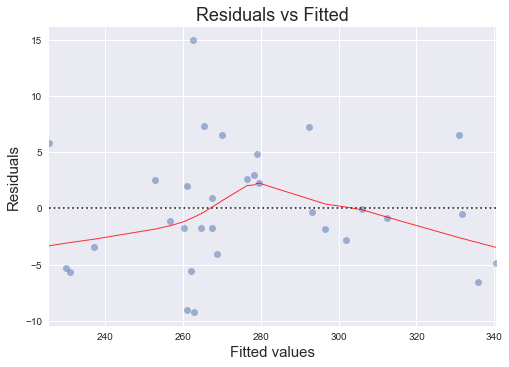

In [66]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


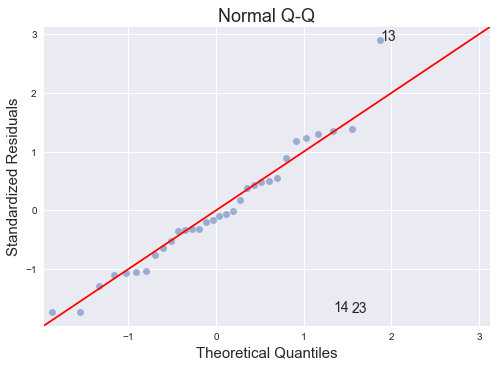

In [67]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


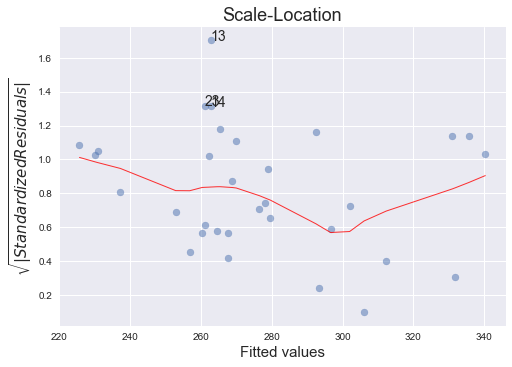

In [68]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
  plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));

<h2>NORM</h2>

In [69]:
stats.jarque_bera(model_residuals)

Jarque_beraResult(statistic=1.6893321655736848, pvalue=0.42970081875732424)

In [70]:
import statsmodels.stats

<h2>NO CORRELATION</h2>

In [71]:
statsmodels.stats.diagnostic.acorr_breusch_godfrey(model_fit, nlags=12)

(15.23264511711021,
 0.22895967568503375,
 1.2869996927537832,
 0.30898964913848154)

<h2>HETERO</h2>

In [72]:
statsmodels.stats.diagnostic.het_breuschpagan(model_fit.resid, model_fit.model.exog)

(0.8070796607307784,
 0.6679514215199628,
 0.3751702294402889,
 0.6904589096129496)

In [24]:
lmbds

      fun: 0.04973858713379703
 hess_inv: array([[ 1.06857016,  0.        , -0.31503582],
       [ 0.        ,  1.        ,  0.        ],
       [-0.31503582,  0.        ,  0.11047457]])
      jac: array([-0.00658217,  0.        ,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 315
      nit: 8
     njev: 76
   status: 2
  success: False
        x: array([ 0.16020046,  0.2       , -0.14239692])

<h1>TASK 2<h1>

In [25]:
with open('troutpcb.txt') as f:
    lines = f.readlines()

In [26]:
full_data = list()

for line in lines:
    arr = line.replace('\t', ' ').replace('\n', '').split()
    arr = list(map(float, arr))
    full_data.append(arr)
full_data = np.array(full_data)

In [27]:
x = full_data[:, 0]
y = full_data[:, 1]

In [28]:
#X = np.log(pd.DataFrame(X_))
#y = np.log(pd.DataFrame(y_))

X = pd.DataFrame(x)
Y = pd.DataFrame(y)

# generate OLS model
model = sm.OLS(Y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, Y for easier plot handling
dataframe = pd.concat([X, Y], axis=1)

In [29]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


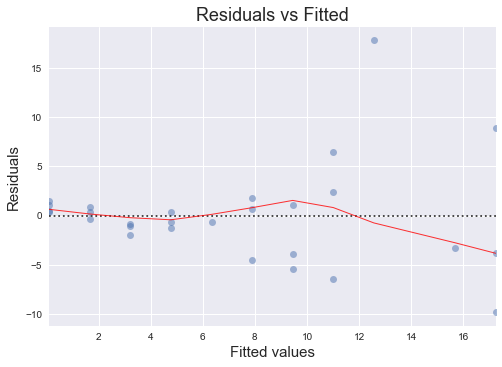

In [30]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


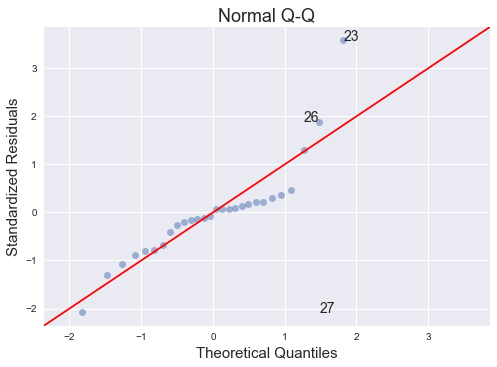

In [31]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


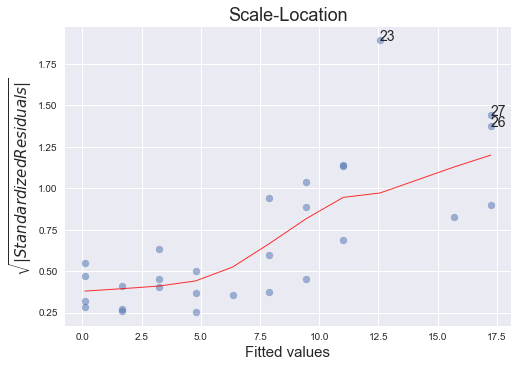

In [32]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
  plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));

<h2>NORM</h2>

In [33]:
stats.jarque_bera(model_residuals)

Jarque_beraResult(statistic=29.618240168119215, pvalue=3.7023789289936104e-07)

In [34]:
import statsmodels.stats

<h2>NO CORRELATION</h2>

In [35]:
statsmodels.stats.diagnostic.acorr_breusch_godfrey(model_fit, nlags=12)

(23.016895426739353,
 0.027582847353165543,
 5.388818209560117,
 0.0019317995838031333)

<h2>HETERO</h2>

In [36]:
statsmodels.stats.diagnostic.het_breuschpagan(model_fit.resid, model_fit.model.exog)

(5.5679025711451136,
 0.01829265996047816,
 6.453496705286151,
 0.017388036938213336)

<h1>BOXCOX</h1>

In [37]:
Xreal = full_data[:, 0]
Yreal = full_data[:, 1]

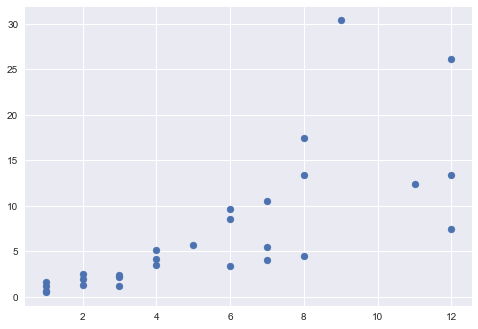

In [38]:
plt.scatter(Xreal, Yreal)

In [39]:
X_ = Xreal
Y_ = Yreal

In [40]:
def get_fitted(x, y):
    X = pd.DataFrame(x)
    Y = pd.DataFrame(y)

    # generate OLS model
    model = sm.OLS(Y, sm.add_constant(X))
    model_fit = model.fit()
    
    model_fitted_y = model_fit.fittedvalues
    
    return model_fitted_y

In [41]:
def func(lmbds):
    x = stats.boxcox(X_, lmbds[0])
    y = ((Y_.prod()**(1/len(Y_)))**(1-lmbds[1]))*stats.boxcox(Y_, lmbds[1])
    fitted = get_fitted(x, y)
    
    return ((fitted - y)**2).sum()

In [42]:
import scipy

In [43]:
lmbds = scipy.optimize.minimize(func, [0.2, 0.1])

In [44]:
lmbds['x']

array([ 0.08984305, -0.10250553])

In [45]:
x = stats.boxcox(X_, lmbds['x'][0])
y = ((Y_.prod()**(1/len(Y_)))**(1-lmbds['x'][1]))*stats.boxcox(Y_, lmbds['x'][1])

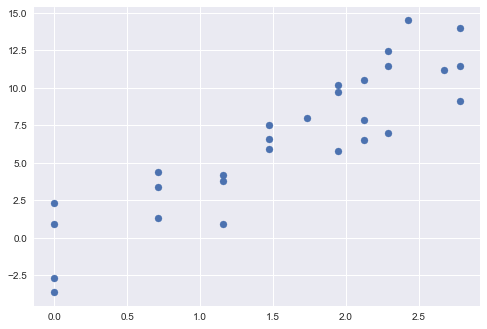

In [46]:
plt.scatter(x, y)

In [47]:
#X = np.log(pd.DataFrame(X_))
#y = np.log(pd.DataFrame(y_))

X = pd.DataFrame(x)
Y = pd.DataFrame(y)

# generate OLS model
model = sm.OLS(Y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, Y for easier plot handling
dataframe = pd.concat([X, Y], axis=1)

In [48]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


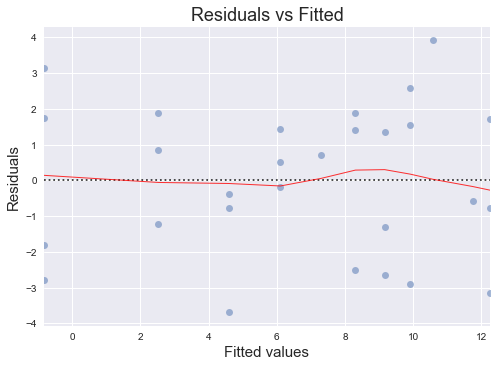

In [49]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


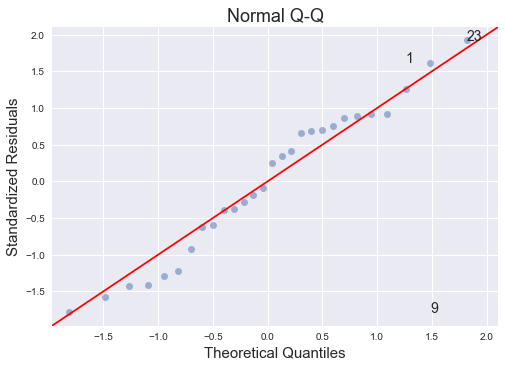

In [50]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

c:\users\nurma\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


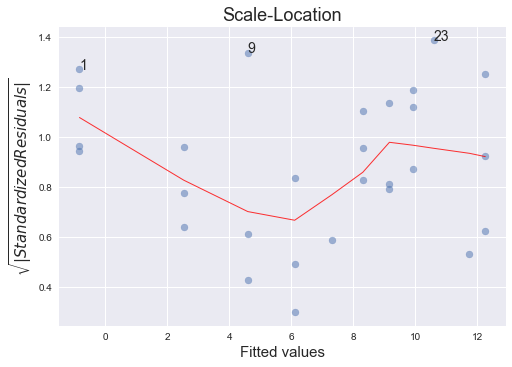

In [51]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
  plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));

<h2>NORM</h2>

In [52]:
stats.jarque_bera(model_residuals)

Jarque_beraResult(statistic=1.2419004331888643, pvalue=0.5374335166444152)

In [53]:
import statsmodels.stats

<h2>NO CORRELATION</h2>

In [54]:
statsmodels.stats.diagnostic.acorr_breusch_godfrey(model_fit, nlags=12)

(12.926194248216504,
 0.37442797464719485,
 1.0004480755942002,
 0.4939347282888823)

<h2>HETERO</h2>

In [55]:
statsmodels.stats.diagnostic.het_breuschpagan(model_fit.resid, model_fit.model.exog)

(0.020520723303116828,
 0.8860922994314552,
 0.019068932648987454,
 0.8912329784273044)